In [19]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import faiss
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm

PATH = "simclr_encoder_final.pth"
class EncoderResNet(nn.Module):
    """ResNet encoder with projection head"""
    def __init__(self, output_dim=128):
        super().__init__()
        
        resnet = torchvision.models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
        
    def forward(self, x):
        h = self.encoder(x).squeeze()
        z = self.projector(h)
        return F.normalize(z, dim=1)

def load_encoder():

    encoder = EncoderResNet(output_dim=128)

    encoder.load_state_dict(torch.load(PATH))
    encoder.eval()
    return encoder

def get_transform():
    return transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def get_embedding(encoder, input_img, device='cuda'):
    """Get the embeddings for an image"""
    image = input_img.convert('RGB')
    transform = get_transform()
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move to device and get embedding
    encoder = encoder.to(device)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        embedding = encoder.encoder(image_tensor).squeeze()
    
    return embedding

def compute_similarity(embedding1, embedding2):
    """Compute cosine similarity between two embeddings"""
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()

def compute_similarity_matrix(embeddings):
    """Compute pairwise cosine similarity matrix for a batch of embeddings"""
    embeddings_normalized = F.normalize(embeddings, dim=1)
    similarity_matrix = torch.mm(embeddings_normalized, embeddings_normalized.t())
    return similarity_matrix

def get_similar_images(reference_embedding, all_embeddings, image_paths, top_k=5):
    """Find top-k most similar images to a reference image"""
    reference_normalized = F.normalize(reference_embedding.unsqueeze(0), dim=1)
    all_normalized = F.normalize(all_embeddings, dim=1)

    similarities = torch.mm(reference_normalized, all_normalized.t()).squeeze()
    
    top_similarities, top_indices = torch.topk(similarities, k=min(top_k, len(image_paths)))
    
    results = []
    for similarity, idx in zip(top_similarities, top_indices):
        results.append({
            'path': image_paths[idx],
            'similarity': similarity.item()
        })
    
    return results

In [12]:
import json
with open("Test.json","r") as file:
    testing = json.load(file)

In [2]:
from scale import process_to_size
# testing
    # set img and img_like to be from the same class (person), then set img_unlike to be a different person
img = process_to_size('./imdb_crop/62/nm0000062_rm28823040_1935-1-8_1964.jpg',target_size=224) # this is elvis
img_like = process_to_size('./imdb_crop/62/nm0000062_rm1884521728_1935-1-8_1966.jpg',target_size=224) # this is elvis
img_unlike = process_to_size('./imdb_crop/78/nm0000078_rm1958133248_1907-5-26_1971.jpg',target_size=224) # this is john wayne
display(img),display(img_like),display(img_unlike)

FileNotFoundError: [Errno 2] No such file or directory: '/projectnb/ds542/students/daf/DS542_final/code/imdb_crop/62/nm0000062_rm28823040_1935-1-8_1964.jpg'

In [3]:
encoder = load_encoder()

embedding1 = get_embedding(encoder, img)
embedding2 = get_embedding(encoder, img_like)
embedding3 = get_embedding(encoder, img_unlike)

similarity12 = compute_similarity(embedding1, embedding2)
similarity13 = compute_similarity(embedding1,embedding3)
print(f"Similarity between images: {similarity12:.4f}") 
print(f"Similarity between images: {similarity13:.4f}")
# if successful, 12 should be greater than 13

NameError: name 'load_encoder' is not defined

In [24]:
# Generates embeddings for all the testing images
image_paths = list(testing)
embeddings = []
for path in tqdm(image_paths):
    embedding = get_embedding(encoder, process_to_size(path,target_size=224), device)
    embeddings.append(embedding)
embeddings = torch.stack(embeddings)

/scratch/1390345.1.academic-gpu/ipykernel_979740/161328097.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(PATH))
100%|██████████| 20


Most similar images to ./imdb_crop/22/nm0000222_rm1514114048_1965-5-31_2010.jpg
Path: ./imdb_crop/22/nm0000222_rm1514114048_1965-5-31_2010.jpg, Similarity: 1.0000
Path: ./imdb_crop/23/nm0001523_rm152737792_1969-12-14_2002.jpg, Similarity: 0.9189
Path: ./imdb_crop/38/nm2189338_rm536710656_1982-1-29_2009.jpg, Similarity: 0.9166
Path: ./imdb_crop/22/nm0421822_rm2862528768_1969-7-13_2009.jpg, Similarity: 0.9085
Path: ./imdb_crop/47/nm1659547_rm3900541184_1985-5-28_2010.jpg, Similarity: 0.9073
Path: ./imdb_crop/69/nm0005569_rm2229963520_1952-11-8_2008.jpg, Similarity: 0.8985
Path: ./imdb_crop/89/nm1378589_rm37389568_1978-10-27_2010.jpg, Similarity: 0.8963
Path: ./imdb_crop/80/nm1531180_rm37389568_1975-9-10_2010.jpg, Similarity: 0.8963
Path: ./imdb_crop/01/nm0001701_rm1076863488_1978-9-7_2010.jpg, Similarity: 0.8936
Path: ./imdb_crop/67/nm1208167_rm1807604224_1976-7-15_2013.jpg, Similarity: 0.8922
Path: ./imdb_crop/10/nm0001610_rm1612486656_1960-11-18_2005.jpg, Similarity: 0.8920
Path: ./im

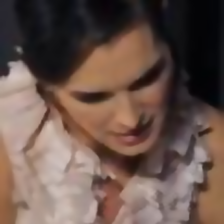

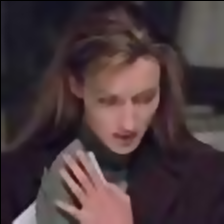

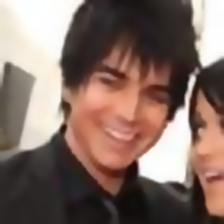

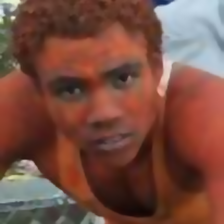

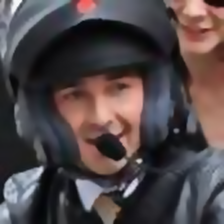

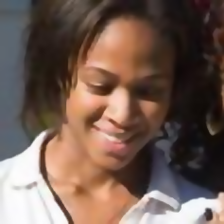

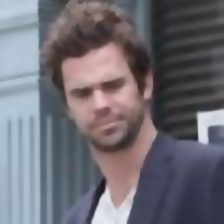

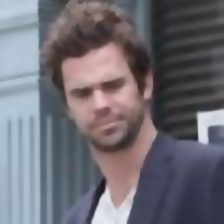

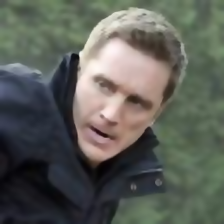

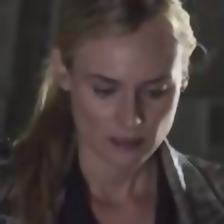

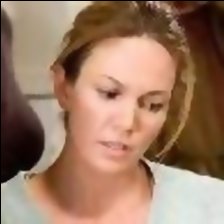

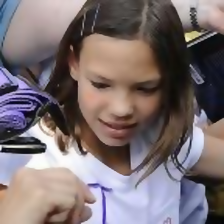

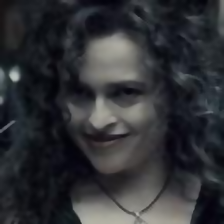

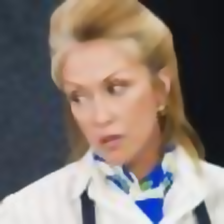

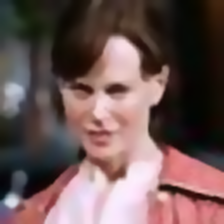

In [60]:
# Use this cell to qualitatively decide if the features look like they're matching

reference_idx =1190 # Testing index of the target image to be retrieved against
similar_images = get_similar_images(
    embeddings[reference_idx],
    embeddings, 
    image_paths,
    top_k=15
)
print("\nMost similar images to", image_paths[reference_idx])
for result in similar_images:
    print(f"Path: {result['path']}, Similarity: {result['similarity']:.4f}")

for i in similar_images:
    display(process_to_size(i['path'],target_size=224))

# similar_images[0]